# IMGEP-MUGL
<center>
    paper available at https://arxiv.org/abs/1807.01521
</center>

In [87]:
import numpy as np
import scipy.stats

%matplotlib notebook
import matplotlib.pyplot as plt

from latentgoalexplo.actors import exploactors
from latentgoalexplo.environments import armballs
from latentgoalexplo.representation import representation_pytorch

In [88]:
def discretized_entropy(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    histp = histp.ravel() / histp.sum()
    return scipy.stats.entropy(histp)

def nb_explored_cells(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    return len(np.where(histp>0)[0])

# Arm Balls

The ArmBalls environment. It is composed of a seven joints robotic arm and of two balls. One of the ball can be grasped by the robotic arm and moved in the scene (the yellow one below). The other ball (the blue one) cannot be moved by the robotic arm and follows a random walk in the environment. The robotic arm is controlled by a controller defined using radial basis function.

Below we show an example of movement produced by the controller. The object size control the easiness for the arm to catch the yellow ball. Note that it does not affect the rendering. The movement is composed of 50 timesteps.

<IPython.core.display.Javascript object>


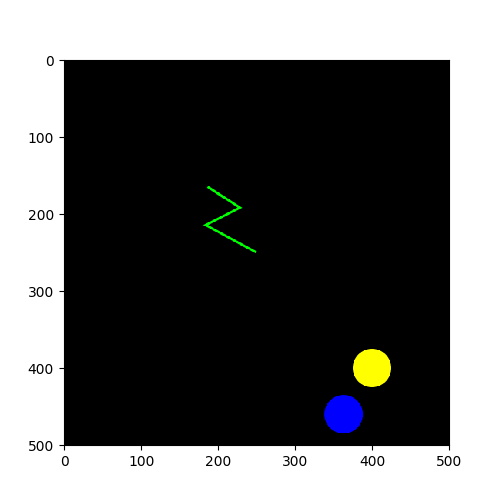

In [90]:
a = armballs.MyArmBalls(arm_lengths=np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]), object_size=0.1,
                        distract_size=0.1, distract_noise=0.1, n_rbf=7, sdev=10., n_timesteps=50, render=True)
a.reset()
# A random motor command
a.act(np.random.randn(len(a.action_space)))

### Example of some exploration algorithms

In this environment an contrary to many environment considered in reinforcement learning, there are no pre-defined rewards. The idea is to find exploration algorithms which are able to autonomously learn actions that produce a wide variety of outcomes. In this specific example since only the yellow ball can be moved it corresponds to being able to move the yellow ball in as many locations as possible.

In [69]:
# we render the action of the exploration algorithm every render_interval epochs
render = True
render_interval = 400
# Configuration for environment
env_config = dict()
env_config.update({'arm_lengths': np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]),
                   'object_size': 0.1, 'distract_size': 0.1, 'distract_noise': 0.1,
                   'n_rbf': 7, 'sdev': 10, 'n_timesteps': 50, 'render_arm': False,
                   'width': 64, 'height': 64, 'render': render, 'render_interval': render_interval})

Below we show an example of a random parameterization experiment. In this experiment the actions are chosen randomly at each epoch. This is the most naive exploration scheme that one can perform since it doesn't use any previous action/outcome pair to chose the next action.

<IPython.core.display.Javascript object>


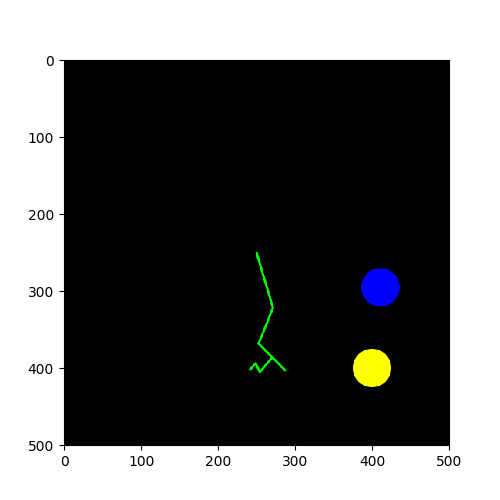

In [78]:
# Random Parameterization Experiment
n_exploration_iterations = 2000
a = exploactors.RandomParameterizationExploration(static_env=armballs.MyArmBalls, **env_config)
a.reset()
a.act(n_iter=n_exploration_iterations, render=render)

In [80]:
# We compute the number of explored cells by the yellow ball in a grid of 30 x 30 cells
nb_explored_cells(np.array(a.outcomes_states), n_bins=50)

35

<IPython.core.display.Javascript object>


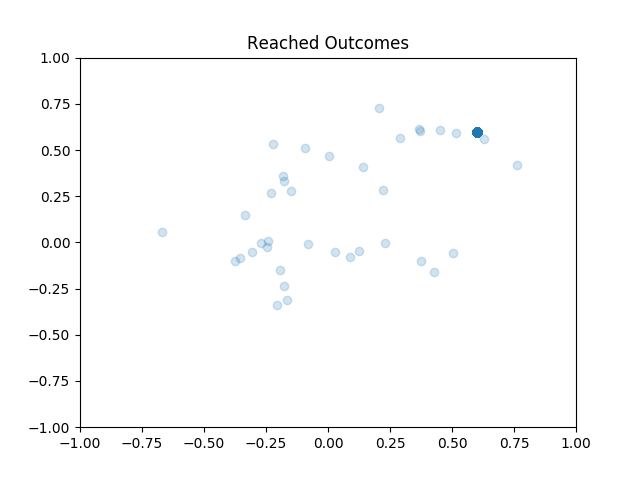

Text(0.5,1,'Reached Outcomes')

In [79]:
# We can plot a scatter plot of the outcomes reached
outcomes = np.array(a.outcomes_states)
plt.figure()
plt.scatter(outcomes[:, 0], outcomes[:, 1], alpha=.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Reached Outcomes")

We see that using a random parameterization algorithm, in most cases the robotic arm has not grabbed the ball and so it has remained in the initial position. This is a terrible strategy in this environment since the probability to catch the ball by when performing a random action is around 0.01.

In our paper we use Intrinsically Motivated Goal Exploration Processes (IMGEPs, see paper for details) to perform exploration. These algorithms were shown to be efficient to explore unknown environments. The idea of IMGEPs is to perform a goal exploration: at each experiment the agent samples a goal that it will try to fullfil. He then performs an experiment using a motor command that reached the closest outcome to the sampled goal. He then adds a bit of noise to this motor command before performing it. This strategy is efficient because it allows the agent to sample more often motor commands which have had an impact on the environment. This type of algorithms was often implemented on enviroments where we have access to the true states of each objects (x and y positions of the two balls).

In our paper we propose an architecture for modular goal exploration when the sensori space is high dimensional (e.g.) in the case of images. The general idea is to learn a representation of the environment using a representation algorithm (typically a variationnal auto-encoder (VAE)). We then define modules which consist of a subset of some latent variables. For example module 1 could correspond to latent 0 and latent 5. The modules are created by grouping together latents which have the same Kullback Leibler divergence. The agent can the chose to set a goal in every module. A goal could corresponds to achieving a final state for which the latents of module 2 have a certain value.

Here we perform a modular goal exploration on a learned goal space. The goal space is learned using a $\beta$-VAE. There are two possible representations that can be used as a goal space during the exploration. One disentangled (large $\beta$) and one that is entangled (standard VAE, $\beta = 1$).

<IPython.core.display.Javascript object>


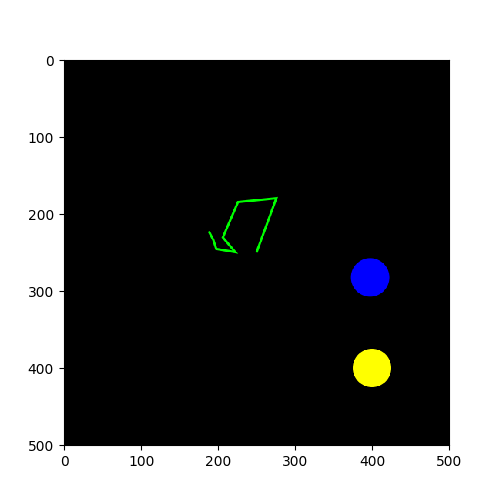

<IPython.core.display.Javascript object>


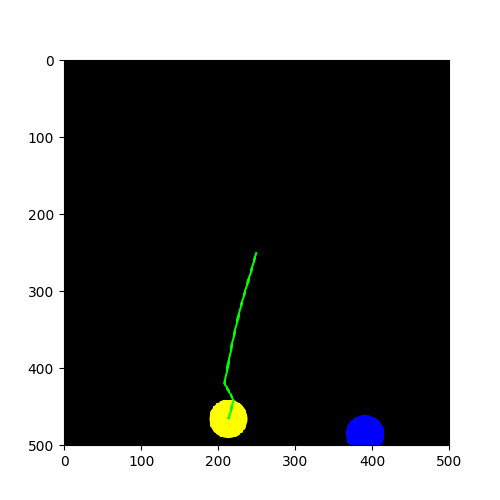

In [85]:
# MGE Vae experiment
n_bootstrap = 400
n_exploration_iterations = 1600
# Disentangled representation
model_path = '../weights/ArmBalls_rgb_BallDistract'
# Entangled representation
# model_path = '../weights/ArmBalls_rgb_BallDistract_ent'


# We observe the ball moving (probably a scientist)
# Used here to estimate KLD for each latents in order to create learning modules
a = armballs.ArmBallsRenderer(**env_config)
a.reset()

training_images = []
for i in range(1000):
    state = np.random.uniform(-1, 1, a.action_space.shape[0])
    a.act(observation=state)
    training_images.append(a.rendering)
training_images = np.array(training_images)

# We perform Bootstrap
a = exploactors.RandomParameterizationExploration(static_env=armballs.MyArmBallsObserved, **env_config)
a.reset()
a.act(n_iter=n_bootstrap, render=render)

# We perform AGE-UGL
b = exploactors.ActiveGoalExplorationUgl(static_env=armballs.MyArmBallsObserved,
                                         representation=representation_pytorch.PytorchBetaVAERepresentation,
                                         n_latents=10, beta=1, initial_epochs=0,
                                         interest_model='normal', n_explore=4, explo_ratio=0.1,
                                         n_modules=5, explo_noise_sdev=0.05, win_size=1000, **env_config)
b.load_representation(actions=a.actions, outcomes=a.outcomes, outcomes_states=a.outcomes_states,
                      outcomes_train=training_images, model_path=model_path)
b.act(n_iter=n_exploration_iterations, render=render)

In [83]:
# We compute the number of explored cells
nb_explored_cells(np.array(b.outcomes_states))
# It is much larger than for the random parameterization experiment

268

<IPython.core.display.Javascript object>


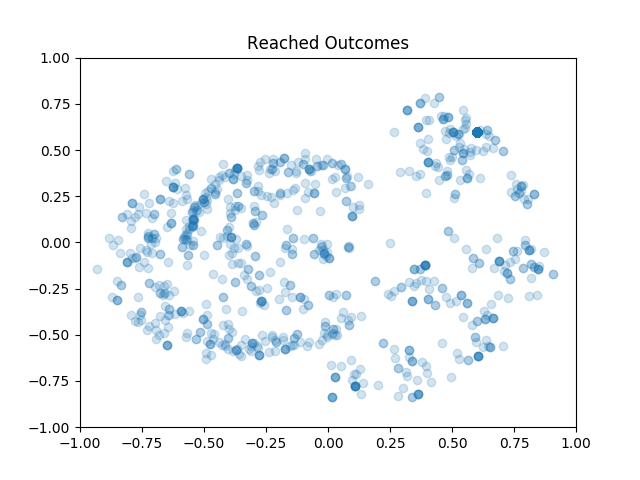

Text(0.5,1,'Reached Outcomes')

In [84]:
# We can plot a scatter plot of the outcomes reached
outcomes = np.array(b.outcomes_states)
plt.figure()
plt.scatter(outcomes[:, 0], outcomes[:, 1], alpha=.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Reached Outcomes")

We see that the number of visited cells is much larger than in the random parameterization case. One can show (see paper for details) that the exploration power using this architecture is in fact as good as when using the true state of the system (x and y positions of the ball that can be grasped).

We can also take a look at the interest of the agent for each of the modules defined by the algorithm. We can see that when the representation is disentangled the interest is high only for module 0. This module correspond to the ball that can be grasped: the agent learns which latent variables can be controlled. This knowledge can later be reused in another algorithm.

<IPython.core.display.Javascript object>


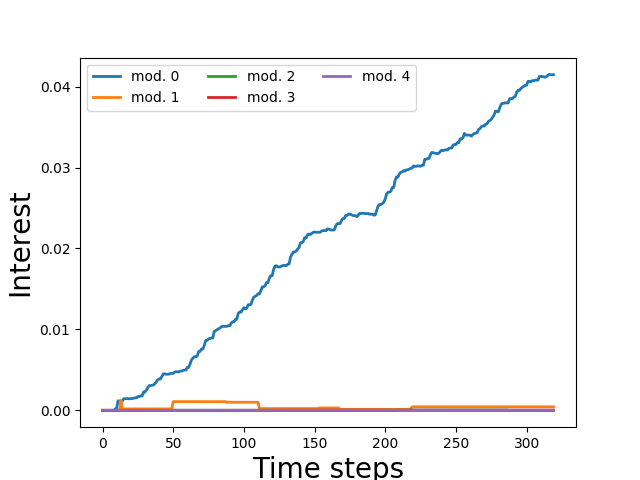

Text(0,0.5,'Interest')

In [86]:
fig, ax = plt.subplots()
ax.plot(b.interests_evolution, lw=2)
ax.legend(["mod. 0", "mod. 1", "mod. 2", "mod. 3", "mod. 4", "mod. 5"], ncol=3)
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Interest', fontsize=20)